<a href="https://colab.research.google.com/github/xelothi/ML-for-kinase-inhibitors-development/blob/main/Prediction_using_Lipinski_descriptors.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Testing different ML models ability to predict CRAF inhibitory molecules based on Lipinski descriptors as features. Lipinksi descriptors are a widely used set of guidelines in medicinal chemistry for evaluating the drug-likeness or pharmacokinetic properties of potential drug compounds. Based on Lipiniski:

*   Molecular weight: should be less than 500 daltons
*   LogP(The octanol-water partition coefficient): should be less than 5.
*   Hydrogen bond donors: >= 5
*   Hydrogen bond acceptors: >= 10
*   Number of rotating bonds: >= 10

In [ ]:
! pip install rdkit

In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics,svm, clone
from sklearn.metrics import accuracy_score, recall_score, roc_auc_score, mean_squared_error
from sklearn.model_selection import train_test_split,KFold
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from rdkit import Chem, DataStructs
from rdkit.Chem import Draw, Descriptors, rdFingerprintGenerator, AllChem, MACCSkeys
from sklearn.preprocessing import MinMaxScaler
import seaborn as sns
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from xgboost import XGBClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.linear_model import LogisticRegression

In [ ]:
df = pd.read_csv("CRAF_cleaned_and_preprocessed_data.csv", index_col=[0])
df.head()

In [ ]:
df["activity"] = df["bioactivity"].apply(lambda x: 1 if x == "active" else 0)
df.shape

In [ ]:
df = df.dropna()
df.shape

# Feature selection
Performing basic feature selection using Pearson correalation. Threshold set is 0.7.

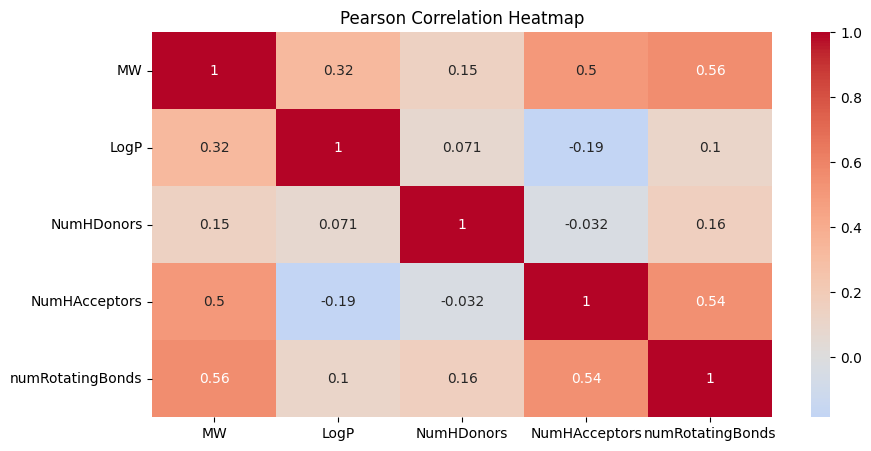

In [62]:
features = ['MW','LogP','NumHDonors','NumHAcceptors', "numRotatingBonds"]
X = df[features]

y = df["activity"]
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y,random_state=42)
# Calculate the Pearson correlation matrix
correlation_matrix = X_train.corr()
# Create a heatmap
plt.figure(figsize=(10, 5))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Pearson Correlation Heatmap')
plt.show()

# Undersampling TomekLinks

In [ ]:
rs = SMOTE(sampling_strategy='auto')
X_train,y_train = rs.fit_resample(X_train,y_train)

#Models


In [ ]:
def model_performance(ml_model, test_x, test_y, verbose=True):
    # Prediction probability on test set
    test_prob = ml_model.predict_proba(test_x)[:, 1]

    # Prediction class on test set
    test_pred = ml_model.predict(test_x)

    # Performance of model on test set
    accuracy = accuracy_score(test_y, test_pred)
    sens = recall_score(test_y, test_pred)
    spec = recall_score(test_y, test_pred, pos_label=0)
    auc = roc_auc_score(test_y, test_prob)
    rmse = mean_squared_error(test_y, test_pred)

    if verbose:
        # Print performance results
        print(f"Accuracy: {accuracy:.2f}")
        print(f"Sensitivity: {sens:.2f}")
        print(f"Specificity: {spec:.2f}")
        print(f"AUC: {auc:.2f}")
        print(f"RMSE: {rmse:.2f}")

    return accuracy, sens, spec, auc,rmse

In [ ]:
def model_training_and_validation(ml_model, name, splits, verbose=True):
    train_x, test_x, train_y, test_y = splits

    # Fit the model
    ml_model = ml_model.fit(train_x, train_y)
    # Calculate model performance results
    accuracy, sens, spec, auc,rmse = model_performance(ml_model, test_x, test_y, verbose)
    return accuracy, sens, spec, auc,rmse

In [ ]:
def plot_roc_curves_for_models(models, test_x, test_y, save_png=False):

    fig, ax = plt.subplots()

    # Below for loop iterates through models list
    for model in models:
        # Select the model
        ml_model = model["model"]
        # Prediction probability on test set
        test_prob = ml_model.predict_proba(test_x)[:, 1]
        # Prediction class on test set
        test_pred = ml_model.predict(test_x)
        # Compute False postive rate and True positive rate
        fpr, tpr, thresholds = metrics.roc_curve(test_y, test_prob)
        # Calculate Area under the curve to display on the plot
        auc = roc_auc_score(test_y, test_prob)
        # Plot the computed values
        ax.plot(fpr, tpr, label=(f"{model['label']} AUC area = {auc:.2f}"))

    # Custom settings for the plot
    ax.plot([0, 1], [0, 1], "r--")
    ax.set_xlabel("False Positive Rate")
    ax.set_ylabel("True Positive Rate")
    ax.set_title("Receiver Operating Characteristic")
    ax.legend(loc="lower right")

#Random Forest

In [14]:
SEED=23

Hyperparameter tuning of Random forest using GridSearch

In [16]:
model_RF = RandomForestClassifier(random_state=SEED)
param_grid = {
    "n_estimators": np.arange(1,210, 1),
    "max_depth": np.arange(1,6,1),
    "criterion": ["gini", "entropy"]
}
grid = GridSearchCV(estimator=model_RF, param_grid=param_grid, scoring="accuracy", verbose=10, n_jobs=1, cv=5)
grid_res = grid.fit(X_train, y_train)

Streaming output truncated to the last 5000 lines.
[CV 1/5; 1591/2090] START criterion=entropy, max_depth=3, n_estimators=128......
[CV 1/5; 1591/2090] END criterion=entropy, max_depth=3, n_estimators=128;, score=0.697 total time=   0.3s
[CV 2/5; 1591/2090] START criterion=entropy, max_depth=3, n_estimators=128......
[CV 2/5; 1591/2090] END criterion=entropy, max_depth=3, n_estimators=128;, score=0.742 total time=   0.3s
[CV 3/5; 1591/2090] START criterion=entropy, max_depth=3, n_estimators=128......
[CV 3/5; 1591/2090] END criterion=entropy, max_depth=3, n_estimators=128;, score=0.778 total time=   0.3s
[CV 4/5; 1591/2090] START criterion=entropy, max_depth=3, n_estimators=128......
[CV 4/5; 1591/2090] END criterion=entropy, max_depth=3, n_estimators=128;, score=0.769 total time=   0.3s
[CV 5/5; 1591/2090] START criterion=entropy, max_depth=3, n_estimators=128......
[CV 5/5; 1591/2090] END criterion=entropy, max_depth=3, n_estimators=128;, score=0.753 total time=   0.3s
[CV 1/5; 1592/

In [18]:
print(f"Best parametars are {grid_res.best_params_} with score of {grid_res.best_score_}")

Best parametars are {'criterion': 'gini', 'max_depth': 5, 'n_estimators': 15} with score of 0.8011111111111111


In [25]:
splits = [X_train, X_test, y_train, y_test]
# Set model parameter for random forest
model_RF = RandomForestClassifier(random_state=SEED)
param = {
    "n_estimators": 15, # number of trees to grows
    "max_depth": 5,
    "criterion": "gini",  # cost function to be optimized for a split
}
performance_measures = model_training_and_validation(model_RF, "RF", splits)

Accuracy: 0.79
Sensitivity: 0.66
Specificity: 0.85
AUC: 0.84
RMSE: 0.21


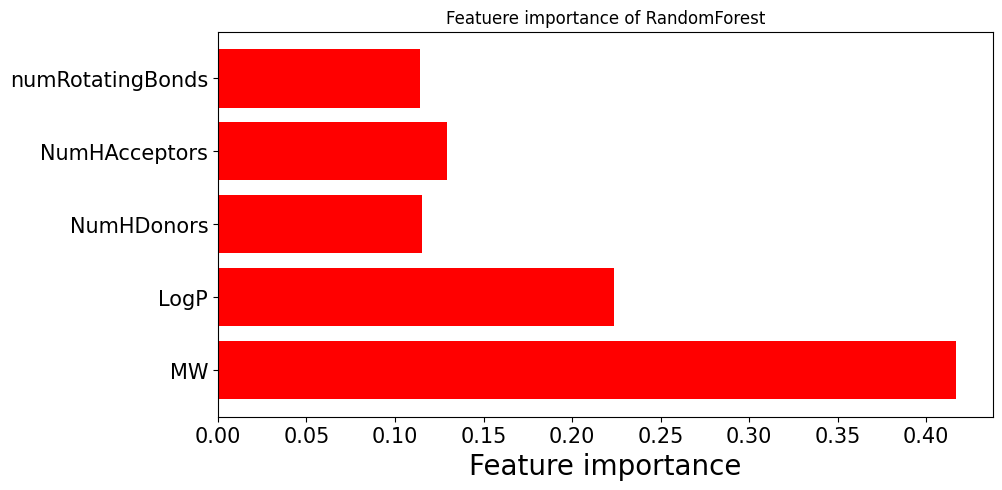

In [26]:
def feature_importance(model, name):
    plt.figure(figsize=(10, 5))
    plt.barh(range(5), model.feature_importances_, color='red')  # Set color to red
    plt.yticks(np.arange(5), features, size=15)
    plt.xticks(size=15)
    plt.xlabel('Feature importance', size=20)
    plt.title(f"Featuere importance of {name}")

feature_importance(model_RF, "RandomForest")

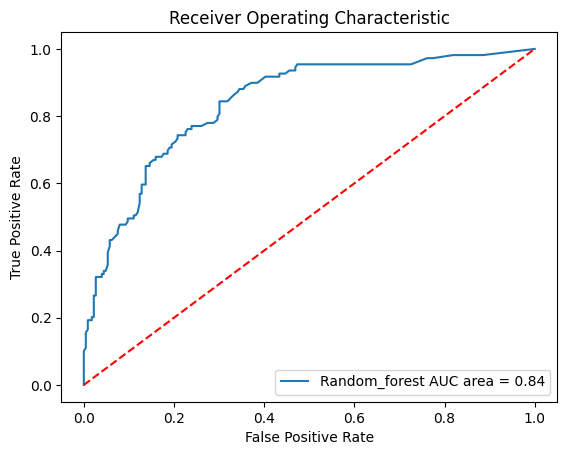

In [27]:
models = [{"label": "Random_forest", "model": model_RF}]
plot_roc_curves_for_models(models, X_test, y_test)

# K-nearest Neighbor

Choosing the best number of neighbors

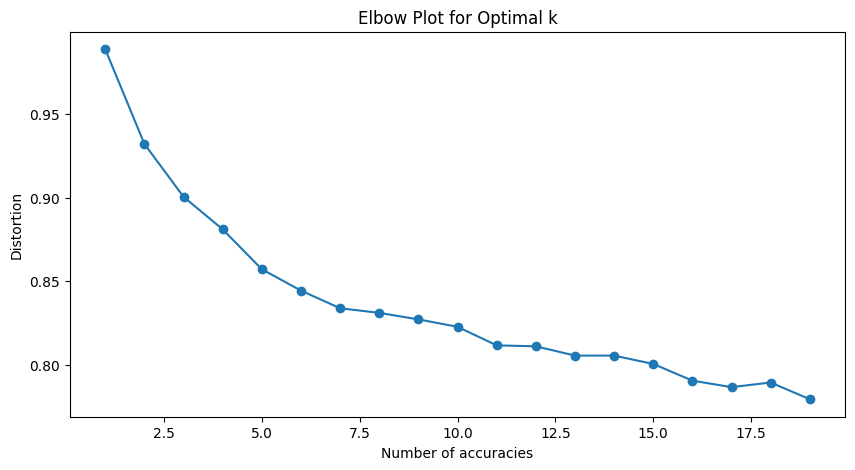

In [28]:
def best_k(splits, num_k):
 X_train, X_test, y_train,y_test = splits
 distortions = []

 for k in range(1, num_k):
        model = KNeighborsClassifier(n_neighbors=k)
        model.fit(X_train, y_train)
        distortions.append(model.score(X_train, y_train))

 plt.figure(figsize=(10,5))
 plt.plot(range(1,num_k), distortions, marker='o')
 plt.xlabel('Number of accuracies')
 plt.ylabel('Distortion')
 plt.title('Elbow Plot for Optimal k')

best_k(splits, 20)

In [31]:
knn_model = KNeighborsClassifier(n_neighbors=15)
performance_measures_knn = model_training_and_validation(knn_model, "KNN_model", splits)

Accuracy: 0.77
Sensitivity: 0.74
Specificity: 0.78
AUC: 0.82
RMSE: 0.23


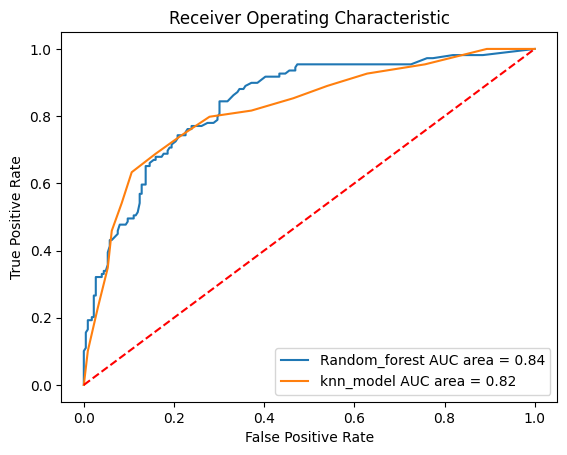

In [32]:
models.append({"label": "knn_model", "model": knn_model})
plot_roc_curves_for_models(models, X_test, y_test)

#XGBoost

In [33]:
xgb = XGBClassifier()
performance_measures_xg = model_training_and_validation(xgb, "XGB", splits)

Accuracy: 0.79
Sensitivity: 0.64
Specificity: 0.85
AUC: 0.82
RMSE: 0.21


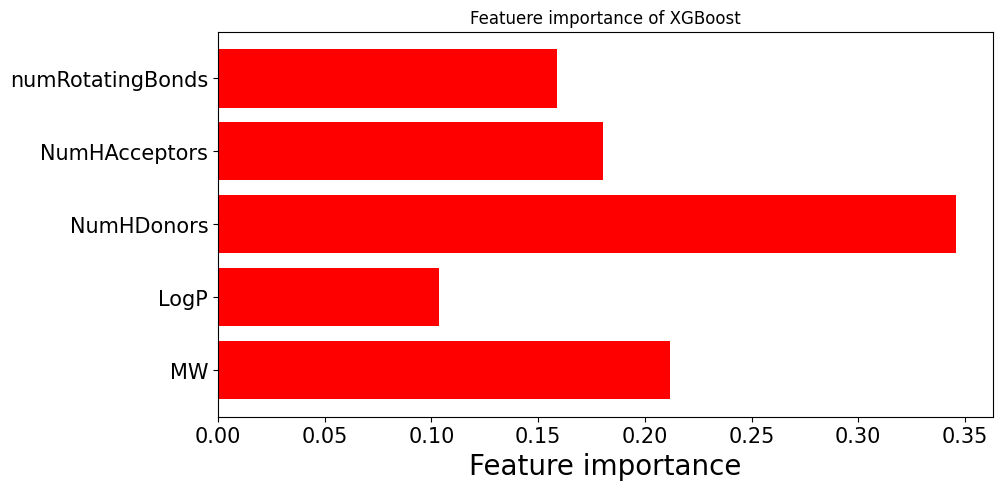

In [34]:
feature_importance(xgb, "XGBoost")

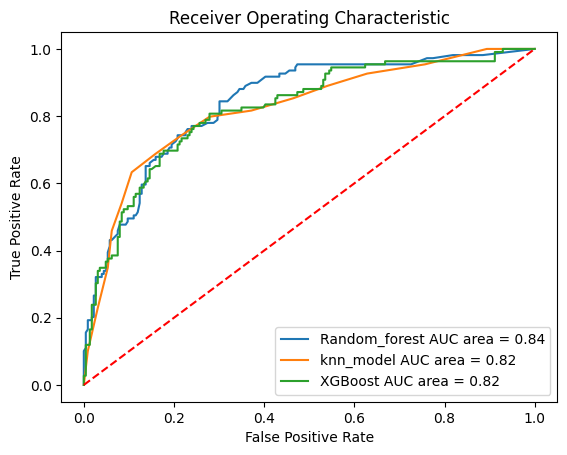

In [35]:
models.append({"label": "XGBoost", "model": xgb})
plot_roc_curves_for_models(models, X_test, y_test)

#SVM

In [36]:
# Specify model
model_SVM = svm.SVC(kernel="rbf", C=1, gamma=0.1, probability=True)

performance_measures_svm_no = model_training_and_validation(model_SVM, "SVM", splits)

Accuracy: 0.77
Sensitivity: 0.69
Specificity: 0.81
AUC: 0.79
RMSE: 0.23


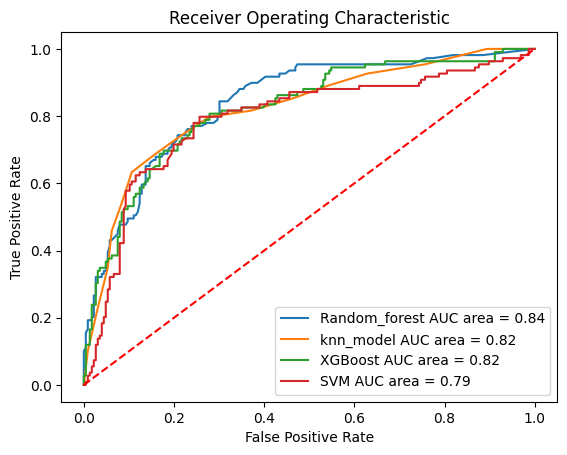

In [37]:
models.append({"label": "SVM", "model": model_SVM})
plot_roc_curves_for_models(models, X_test, y_test)

# Artificial Neural Networks

In [39]:
mlp = MLPClassifier(random_state=0,max_iter=2000).fit(X_train, y_train)
performance_measures_mlp = model_training_and_validation(mlp, "mlp", splits)

Accuracy: 0.73
Sensitivity: 0.39
Specificity: 0.89
AUC: 0.72
RMSE: 0.27


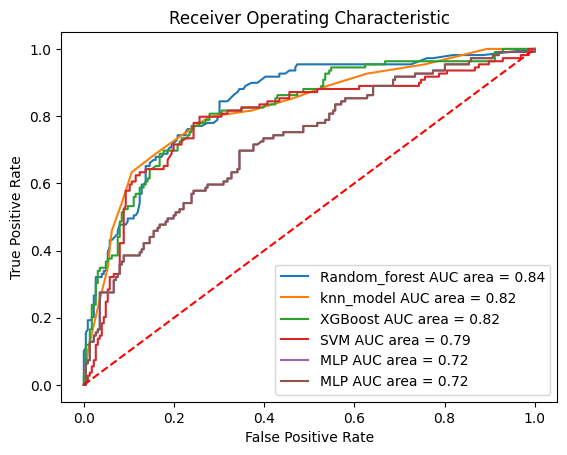

In [59]:
models.append({"label": "MLP", "model": mlp})
plot_roc_curves_for_models(models, X_test, y_test)

# Cross validation

In [49]:
def crossvalidation(model, df, n_folds, verbose=False):

    kfold = KFold(n_splits=n_folds, shuffle=True, random_state=SEED)

    acc = []
    sen = []
    spe = []
    AUC = []
    RMSE = []

    features = ['MW','LogP','NumHDonors','NumHAcceptors', "numRotatingBonds"]

    for train_index, test_index in kfold.split(df):
        # clone model -- we want a fresh copy per fold!
        fold_model = clone(model)
        # Training

        # Convert the fingerprint and the label to a list
        train_x = df.iloc[train_index][features].values.tolist()
        train_y = df.iloc[train_index].activity.tolist()


        # Fit the model
        fold_model.fit(train_x, train_y)

        # Testing

        # Convert the fingerprint and the label to a list
        test_x = df.iloc[test_index][features].values.tolist()
        test_y = df.iloc[test_index].activity.tolist()

        # Performance for each fold
        accuracy, sens, spec, auc, rmse = model_performance(fold_model, test_x, test_y, verbose)
        acc.append(accuracy)
        sen.append(sens)
        spe.append(spec)
        AUC.append(auc)
        RMSE.append(rmse)


    # Print statistics of results
    print(f"Mean accuracy: {np.mean(acc):.2f} \t"
        f"and std : {np.std(acc):.2f} \n"
        f"Mean sensitivity: {np.mean(sen):.2f} \t"
        f"and std : {np.std(sen):.2f} \n"
        f"Mean specificity: {np.mean(spe):.2f} \t"
        f"and std : {np.std(spe):.2f} \n"
        f"Mean AUC: {np.mean(AUC):.2f} \t"
        f"and std : {np.std(AUC):.2f} \n"
        f"Mean RMSE: {np.mean(RMSE):.2f} \t"
        f"and std : {np.std(RMSE):.2f} \n"

    )
    mean_acc = np.mean(acc)
    mean_sen = np.mean(sen)
    mean_spec = np.mean(spec)
    mean_AUC = np.mean(AUC)
    mean_RMSE = np.mean(RMSE)

    return [mean_acc, mean_sen, mean_spec, mean_AUC, mean_RMSE]


In [50]:
cross_val = {}
for model in models:
    print("\n======= ")
    print(f"{model['label']}")
    m = crossvalidation(model["model"], df, n_folds=10)
    label = model['label']
    cross_val[label] = m


Random_forest
Mean accuracy: 0.80 	and std : 0.02 
Mean sensitivity: 0.63 	and std : 0.06 
Mean specificity: 0.88 	and std : 0.03 
Mean AUC: 0.85 	and std : 0.02 
Mean RMSE: 0.20 	and std : 0.02 


knn_model
Mean accuracy: 0.78 	and std : 0.03 
Mean sensitivity: 0.55 	and std : 0.05 
Mean specificity: 0.89 	and std : 0.02 
Mean AUC: 0.79 	and std : 0.04 
Mean RMSE: 0.22 	and std : 0.03 


XGBoost
Mean accuracy: 0.79 	and std : 0.02 
Mean sensitivity: 0.63 	and std : 0.06 
Mean specificity: 0.87 	and std : 0.03 
Mean AUC: 0.83 	and std : 0.03 
Mean RMSE: 0.21 	and std : 0.02 


SVM
Mean accuracy: 0.78 	and std : 0.03 
Mean sensitivity: 0.52 	and std : 0.04 
Mean specificity: 0.91 	and std : 0.02 
Mean AUC: 0.80 	and std : 0.02 
Mean RMSE: 0.22 	and std : 0.03 


MLP
Mean accuracy: 0.69 	and std : 0.04 
Mean sensitivity: 0.16 	and std : 0.18 
Mean specificity: 0.95 	and std : 0.07 
Mean AUC: 0.70 	and std : 0.04 
Mean RMSE: 0.31 	and std : 0.04 



In [51]:
df2 = pd.DataFrame(cross_val, index=["Accuracy", "Sensitivity", "Specificity", "AUC", "RMSE"])
df2 = df2.T
df2

,Accuracy,Sensitivity,Specificity,AUC,RMSE
Random_forest,0.800114,0.630370,0.908257,0.853330,0.199886
knn_model,0.777367,0.546729,0.889908,0.791397,0.222633
XGBoost,0.786359,0.626714,0.908257,0.826202,0.213641
SVM,0.782164,0.515616,0.899083,0.795604,0.217836
MLP,0.692383,0.160998,0.853211,0.703306,0.307617


Text(0.5, 1.0, 'Model performances after K-fold cross-validation')

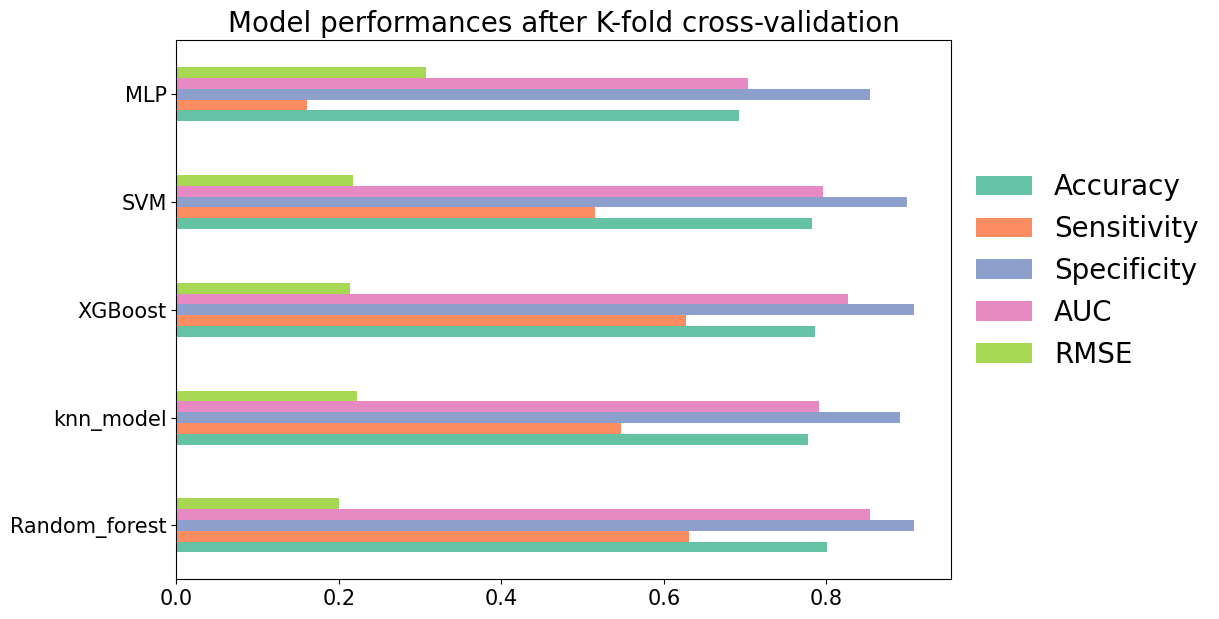

In [44]:
color=sns.color_palette('Set2')
feat = ["Accuracy","Sensitivity", "Specificity", "AUC", "RMSE"]
df2[feat].plot.barh(figsize=(10,7),color=color)
plt.legend(frameon=False,bbox_to_anchor=(1,0.8), prop={'size':20})
plt.xticks(size=15)
plt.yticks(size=15)
plt.title('Model performances after K-fold cross-validation',size=20)

# Stacking ensemble models
Choosing the three best performing models and turning them into ensembl model.

In [58]:
estimators = [("RandomForest", model_RF), ("KNN", knn_model), ("XGBoost", xgb)]
stack_model = StackingClassifier(estimators=estimators, final_estimator=LogisticRegression())

measure_performance_stack = model_training_and_validation(stack_model, "Stack_model", splits)

Accuracy: 0.79
Sensitivity: 0.70
Specificity: 0.84
AUC: 0.85
RMSE: 0.21


Stacked model performs slightly better than the other single ML models.

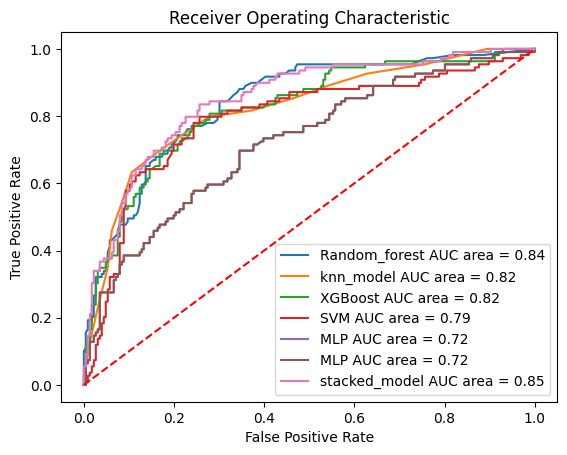

In [60]:
models.append({"label": "stacked_model", "model": stack_model})
plot_roc_curves_for_models(models, X_test, y_test)

Crossvalidation of the stack_model

In [61]:
crossvalidation(stack_model, df,10)

Mean accuracy: 0.79 	and std : 0.03 
Mean sensitivity: 0.48 	and std : 0.05 
Mean specificity: 0.94 	and std : 0.02 
Mean AUC: 0.83 	and std : 0.04 
Mean RMSE: 0.21 	and std : 0.03 



[0.7887332477901341,
 0.4830058645438193,
 0.9357798165137615,
 0.8277297128884851,
 0.211266752209866]